# Clustering CVRP instances with AI
Authors: Laura de Faria Maranhão Ayres and Eduardo Luiz Araujo dos Santos

In [ ]:
!pip install -U pandas-profiling
!pip install -U yellowbrick
!pip install hdbscan

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("seaborn")
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource, CrosshairTool
from bokeh.palettes import Category10
from bokeh.plotting import save, output_file
from sklearn import metrics
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 73.1 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=c1a88315ed3ffd3d6b969065ba49d975ac53aed098d90ec5655a675784c7ce3f
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attemp

<ipython-input-1-21a9eb247b66>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/eduardovegas/CVRP_DATA/main/cvrp_data_3k.csv")
# print(df.info())
df

,name,dimension,capacity,density,avg_demand,std_demand,depot_x_location_ratio,depot_y_location_ratio,demand_to_capacity_ratio,hull_to_square_ratio,num_clusters,std_cluster_size,avg_cluster_distance,std_cluster_distance
0,A-n36-k5,36,100,0.004673,12.628571,6.589143,0.152174,0.191489,4.420000,0.890842,6,2.236068,56.031526,27.540086
1,A-n63-k9,63,100,0.007261,14.080645,7.415753,0.918367,0.938776,8.730000,0.903374,9,2.000000,63.892960,31.373934
2,A-n34-k5,34,100,0.004721,13.939394,7.241113,0.750000,0.347826,4.600000,0.815444,6,3.872983,45.370062,18.992870
3,A-n33-k6,33,100,0.004640,16.906250,11.397112,0.370787,0.326316,5.410000,0.841218,8,2.000000,44.215902,16.798289
4,A-n63-k10,63,100,0.007361,15.032258,9.824639,0.757576,0.750000,9.320000,0.864545,9,2.000000,48.372900,22.879270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,XML100_1375_18,101,178,0.000121,10.760000,18.205405,0.597549,0.538954,6.044944,0.910979,8,7.348469,362.371268,136.324705
3203,XML100_1372_13,101,130,0.000124,25.370000,33.024831,0.668763,0.630123,19.515385,0.874290,10,8.246211,359.290614,163.195128
3204,XML100_1366_17,101,1682,0.000117,44.770000,27.321082,0.526849,0.014614,2.661712,0.916514,9,5.567764,522.274308,238.060361
3205,XML100_1371_12,101,126,0.000121,27.290000,33.588807,0.452609,0.322105,21.658730,0.938545,8,6.244998,380.434721,146.712218


In [ ]:
def show_corr(df, title, dims):
  corr = df.corr(numeric_only=True)
  plt.figure(figsize=dims)
  plt.title(title)
  sns.heatmap(corr, annot=True)
  plt.show()

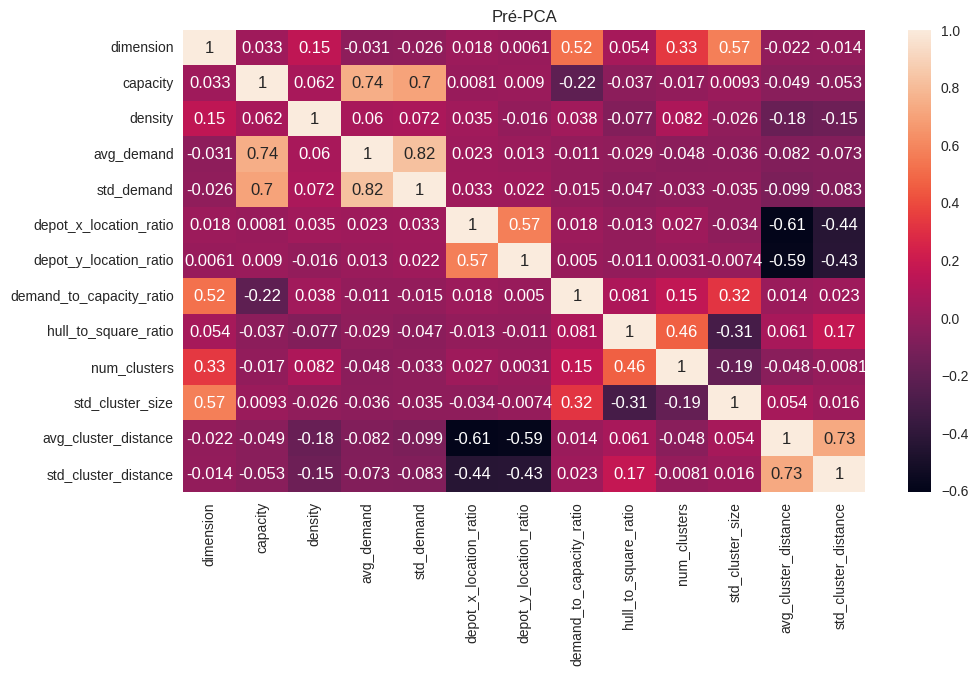

In [ ]:
# Separando as colunas que tem e não tem apenas valores entre 0 e 1
numeric_columns = df.select_dtypes(include=[np.number])
columns_in_range = numeric_columns.columns[numeric_columns.apply(lambda column: column.between(0, 1).all())].tolist()
columns_to_standardize = [col for col in df.columns.to_numpy() if col not in columns_in_range and col != 'name']

# Aplicando a padronização
standardized_df = df.copy()
scaler = StandardScaler()
standardized_df[columns_to_standardize] = scaler.fit_transform(standardized_df[columns_to_standardize])

# Atualizando o DataFrame original com a padronização
df.update(standardized_df[columns_to_standardize])

show_corr(df, "Pré-PCA", (11,6))

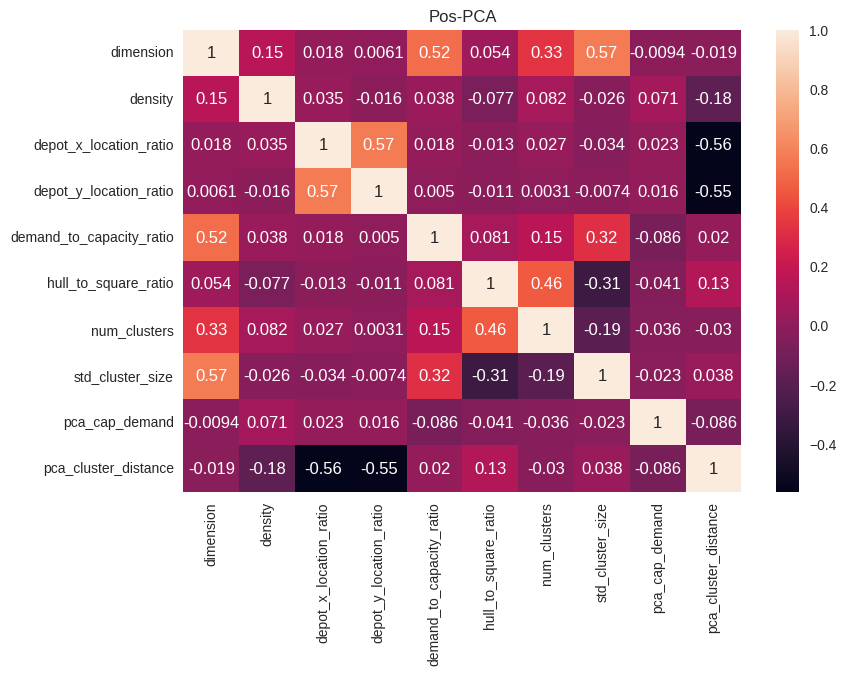

In [ ]:
cols_to_pca = ['capacity', 'avg_demand', 'std_demand']
pca = PCA(n_components = 1)
pca_data = df[cols_to_pca]
pca_result = pca.fit_transform(pca_data)
df['pca_cap_demand'] = pca_result
df.drop(columns=cols_to_pca, inplace=True)


cols_to_pca = ['avg_cluster_distance', 'std_cluster_distance']
pca = PCA(n_components = 1)
pca_data = df[cols_to_pca]
pca_result = pca.fit_transform(pca_data)
df['pca_cluster_distance'] = pca_result
df.drop(columns=cols_to_pca, inplace=True)


show_corr(df, "Pos-PCA", (9,6))

In [ ]:
# Recupera o nome das instâncias, o subset de instâncias do conjunto X, e remove a coluna de nome
instance_names = df['name'].copy().to_numpy()
X_set = df[df['name'].str.startswith('X-n')].copy()
X_set.drop('name', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)

In [ ]:
df

,dimension,density,depot_x_location_ratio,depot_y_location_ratio,demand_to_capacity_ratio,hull_to_square_ratio,num_clusters,std_cluster_size,pca_cap_demand,pca_cluster_distance
0,-0.904493,0.004673,0.152174,0.191489,-0.626665,0.890842,-0.846506,-0.915936,-0.545009,-3.143700
1,-0.591913,0.007261,0.918367,0.938776,-0.290091,0.903374,0.583812,-0.975149,-0.520378,-3.084173
2,-0.927647,0.004721,0.750000,0.347826,-0.612608,0.815444,-0.846506,-0.505354,-0.523659,-3.251679
3,-0.939224,0.004640,0.370787,0.326316,-0.549354,0.841218,0.107040,-0.975149,-0.450154,-3.273700
4,-0.591913,0.007361,0.757576,0.750000,-0.244017,0.864545,0.583812,-0.975149,-0.486693,-3.209228
...,...,...,...,...,...,...,...,...,...,...
3202,-0.151985,0.000121,0.597549,0.538954,-0.499771,0.910979,0.107040,0.366393,-0.405434,-1.154620
3203,-0.151985,0.000124,0.668763,0.630123,0.552155,0.874290,1.060585,0.591571,-0.128600,-0.947007
3204,-0.151985,0.000117,0.526849,0.014614,-0.763972,0.916514,0.583812,-0.080256,1.080482,0.249528
3205,-0.151985,0.000121,0.452609,0.322105,0.719532,0.938545,0.107040,0.089612,-0.103675,-1.004995


In [ ]:
def apply_elbow_evaluation_method(x, algo, K, seed, dims=(9,6)):
  visualizer = KElbowVisualizer(algo, k=K, random_state=seed, timings=False)
  plt.figure(figsize=dims)
  visualizer.fit(x)
  visualizer.show()
  return visualizer.elbow_value_

def run_algo(x, algo):
    algo.fit_predict(x)
    _, cluster_sizes = np.unique(algo.labels_, return_counts=True)
    return algo.labels_, cluster_sizes

def visualize_clustering_results(df, X_set, instance_names, cluster_labels, cluster_sizes, title, width=800, height=600):
  pca = PCA(n_components=2)
  df_pca = pca.fit_transform(df)
  X_set_pca = pca.transform(X_set)

  nb_clusters = len(cluster_sizes)
  nb_colors = nb_clusters if nb_clusters > 2 else 3
  offset = 0 - min(cluster_labels)

  # Create a color palette for the clusters
  colors = Category10[nb_colors]
  # Map cluster assignments to colors
  cluster_colors = [colors[label + offset] for label in cluster_labels]

  # Create a new figure
  p = figure(title=title, plot_width=width, plot_height=height)
  # Create a ColumnDataSource with the PCA coordinates and cluster labels
  df_source = ColumnDataSource(data=dict(
      x=df_pca[:, 0],
      y=df_pca[:, 1],
      instance_names=instance_names,
      cluster_labels=cluster_labels,
      cluster_colors=cluster_colors
  ))

  # Add scatter plot glyphs for all instances
  scatter_all = p.scatter('x', 'y', source=df_source, size=8, color='cluster_colors')
  # Add scatter plot glyphs for subset instances
  p.scatter(X_set_pca[:, 0], X_set_pca[:, 1], size=12, marker='x', color='black')

  # Create tooltips to display instance names and cluster labels
  tooltips = [
      ('Instance', '@instance_names'),
      ('Cluster', '@cluster_labels')
  ]
  p.toolbar.active_inspect = None
  # Add hover tool with tooltips
  p.add_tools(HoverTool(renderers=[scatter_all], tooltips=tooltips))
  # Add crosshair tool to highlight the clicked point
  crosshair_tool = CrosshairTool(line_color='gray', line_width=1)
  p.add_tools(crosshair_tool)

  # Show the plot in Jupyter Notebook
  output_notebook()
  show(p)

  return p

# KMEANS

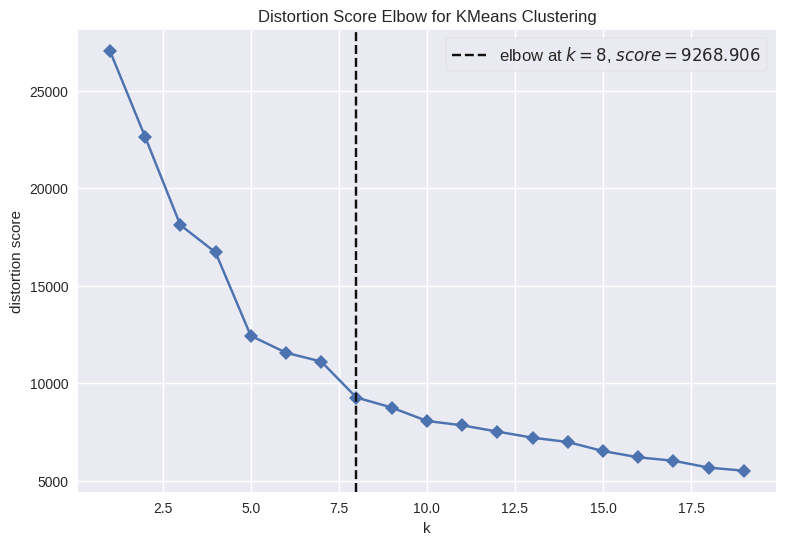

In [ ]:
K = (1, 20)
seed = 42
algo = KMeans(random_state=seed, n_init="auto")
optimal_K = apply_elbow_evaluation_method(df, algo, K, seed)

In [ ]:
percentage=[]
index = []

algo = KMeans(n_clusters=optimal_K, random_state=seed, n_init="auto")
cluster_labels, cluster_sizes = run_algo(df, algo)
title = "KMeans Clustering Results"
p = visualize_clustering_results(df, X_set, instance_names, cluster_labels, cluster_sizes, title)
X_set_clusters = {}

for (i, name) in enumerate(instance_names):

  if name.startswith("X-n"):
    c = cluster_labels[i]
    if c in X_set_clusters:
      X_set_clusters[c] += 1
    else:
      X_set_clusters[c] = 1

for (X_cluster, X_size) in X_set_clusters.items():
  print(f"Cluster {X_cluster}: {X_size} are X-set, {cluster_sizes[X_cluster]} in total")

  if X_size != 0:
    percentage.append((X_size/cluster_sizes[X_cluster])*100)
    index.append(X_cluster)

output_file("kmeans_clustering_results.html", title=title)
save(p)

Cluster 5: 22 are X-set, 360 in total
Cluster 0: 12 are X-set, 1012 in total
Cluster 3: 43 are X-set, 56 in total
Cluster 1: 9 are X-set, 468 in total
Cluster 4: 10 are X-set, 485 in total
Cluster 7: 4 are X-set, 820 in total


'/content/kmeans_clustering_results.html'

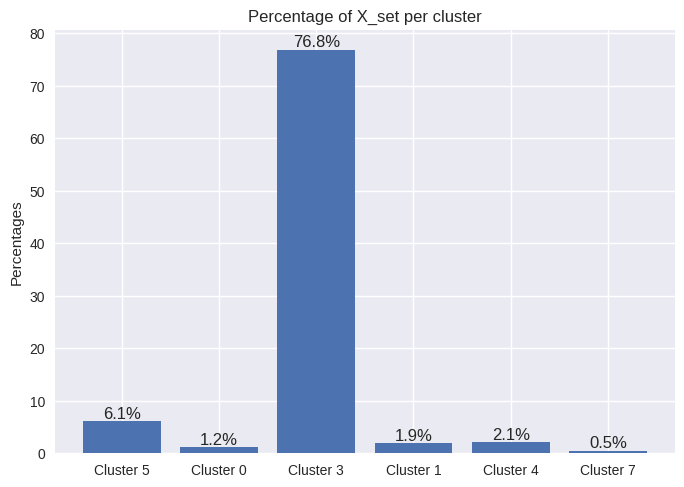

Index with the highest percentage: 2


In [ ]:
# Rótulos para o gráfico
labels = [f'Cluster {index[i]}' for i in range(len(index))]

# Encontrar o índice com a maior porcentagem
best_percentage = percentage.index(max(percentage))
# Configuração do gráfico de barras
plt.bar(labels, percentage)

# Adicionar as porcentagens nos topos das barras
for i, v in enumerate(percentage):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Título do gráfico
plt.title('Percentage of X_set per cluster')
# Eixo
plt.ylabel('Percentages')

# Exibição do gráfico
plt.show()

# Imprimir o índice com a maior porcentagem
print(f"Index with the highest percentage: {best_percentage}")


# AGGLOMERATIVE

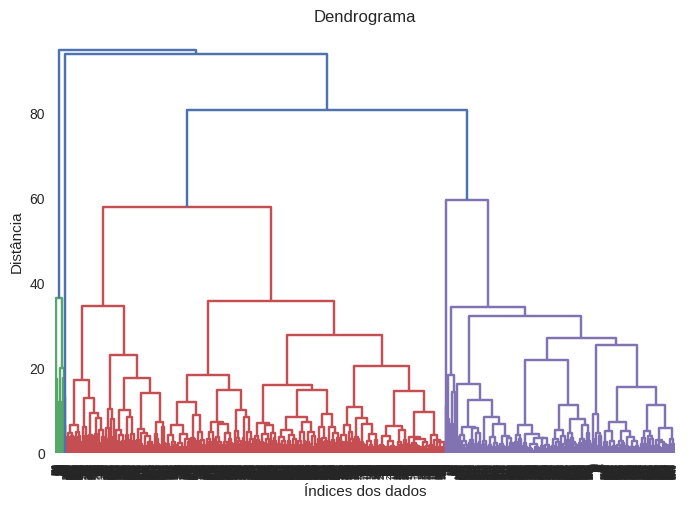

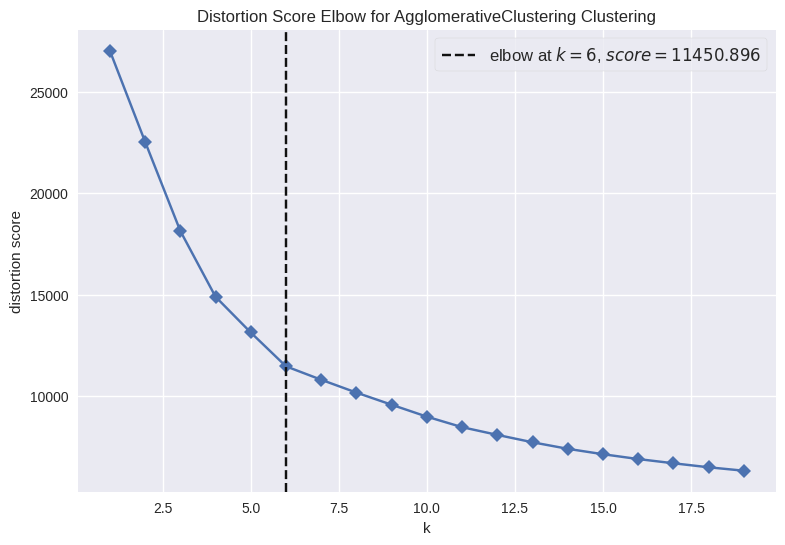

In [ ]:

from scipy.cluster.hierarchy import dendrogram, linkage
algo = AgglomerativeClustering(linkage="ward")
# Realize o agrupamento
algo.fit(df)

# Calcule a estrutura de ligação
linkage_matrix = linkage(df, method='ward')  # Pode ser usado outro método, como 'single', 'complete', 'average', etc.

# Crie o dendrograma
dendrogram(linkage_matrix)

# Exiba o dendrograma
plt.title('Dendrograma')
plt.xlabel('Índices dos dados')
plt.ylabel('Distância')
plt.show()

optimal_K = apply_elbow_evaluation_method(df, algo, K, seed)

In [ ]:
percentage=[]
index = []

algo = AgglomerativeClustering(linkage="ward", n_clusters=optimal_K)
cluster_labels, cluster_sizes = run_algo(df, algo)
title = "Agglomerative Clustering Results"
p = visualize_clustering_results(df, X_set, instance_names, cluster_labels, cluster_sizes, title)
X_set_clusters = {}

for (i, name) in enumerate(instance_names):
  if name.startswith("X-n"):
    c = cluster_labels[i]
    if c in X_set_clusters:
      X_set_clusters[c] += 1
    else:
      X_set_clusters[c] = 1

for (X_cluster, X_size) in X_set_clusters.items():
  print(f"Cluster {X_cluster}: {X_size} are X-set, {cluster_sizes[X_cluster]} in total")
  if X_size != 0:
    percentage.append((X_size/cluster_sizes[X_cluster])*100)
    index.append(X_cluster)

output_file("agglo_clustering_results.html", title=title)
save(p)

Cluster 3: 39 are X-set, 1180 in total
Cluster 1: 10 are X-set, 1447 in total
Cluster 0: 40 are X-set, 53 in total
Cluster 2: 11 are X-set, 521 in total


'/content/agglo_clustering_results.html'

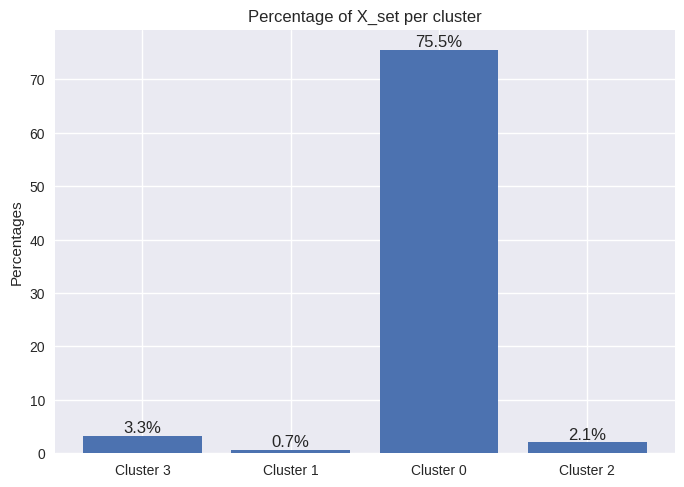

Index with the highest percentage: 2


In [ ]:
# Rótulos para o gráfico
labels = [f'Cluster {index[i]}' for i in range(len(index))]

# Encontrar o índice com a maior porcentagem
best_percentage = percentage.index(max(percentage))
# Configuração do gráfico de barras
plt.bar(labels, percentage)

# Adicionar as porcentagens nos topos das barras
for i, v in enumerate(percentage):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Título do gráfico
plt.title('Percentage of X_set per cluster')
# Eixo
plt.ylabel('Percentages')

# Exibição do gráfico
plt.show()

# Imprimir o índice com a maior porcentagem
print(f"Index with the highest percentage: {best_porcentage}")

In [ ]:
df

,dimension,density,depot_x_location_ratio,depot_y_location_ratio,demand_to_capacity_ratio,hull_to_square_ratio,num_clusters,std_cluster_size,pca_cap_demand,pca_cluster_distance
0,-0.904493,0.004673,0.152174,0.191489,-0.626665,0.890842,-0.846506,-0.915936,-0.545009,-3.143700
1,-0.591913,0.007261,0.918367,0.938776,-0.290091,0.903374,0.583812,-0.975149,-0.520378,-3.084173
2,-0.927647,0.004721,0.750000,0.347826,-0.612608,0.815444,-0.846506,-0.505354,-0.523659,-3.251679
3,-0.939224,0.004640,0.370787,0.326316,-0.549354,0.841218,0.107040,-0.975149,-0.450154,-3.273700
4,-0.591913,0.007361,0.757576,0.750000,-0.244017,0.864545,0.583812,-0.975149,-0.486693,-3.209228
...,...,...,...,...,...,...,...,...,...,...
3202,-0.151985,0.000121,0.597549,0.538954,-0.499771,0.910979,0.107040,0.366393,-0.405434,-1.154620
3203,-0.151985,0.000124,0.668763,0.630123,0.552155,0.874290,1.060585,0.591571,-0.128600,-0.947007
3204,-0.151985,0.000117,0.526849,0.014614,-0.763972,0.916514,0.583812,-0.080256,1.080482,0.249528
3205,-0.151985,0.000121,0.452609,0.322105,0.719532,0.938545,0.107040,0.089612,-0.103675,-1.004995


# DBSCAN

* https://www.analyticsvidhya.com/blog/2021/06/understand-the-dbscan-clustering-algorithm/





In [ ]:
df.shape

(3207, 10)

In [ ]:
# Valores para eps e min_samples
eps_values = np.linspace(0.1, 3, num=30)
min_samples_values = range(1, 11)

# Lista para armazenar as métricas de avaliação
silhouette_scores = []

best_eps = None
best_min_samples = None
best_silhouette = -1

# Loop para percorrer os valores de eps e min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df)
        n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        # Verificar se há apenas um único cluster, o que resulta em uma silhueta indefinida
        if len(np.unique(labels)) == 1:
            continue

        # Calcular a métrica de silhueta
        silhouette = silhouette_score(df, labels)
        silhouette_scores.append(silhouette)

        # Verificar se a métrica de silhueta atual é melhor que a melhor encontrada até o momento
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_eps = eps
            best_min_samples = min_samples
            cluster_labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_noise_ = list(cluster_labels).count(-1)
_, cluster_sizes = np.unique(cluster_labels, return_counts=True)

print("Estimated number of clusters: %d" % (n_clusters_ +1))
print("Estimated number of noise points: %d" % n_noise_)

# Print best values for eps, min_samples and silhouette
print("Best eps value:", best_eps)
print("Best min_samples value:", best_min_samples)
print("Best silhouette Coefficient:", best_silhouette)

Estimated number of clusters: 2
Estimated number of noise points: 32
Best eps value: 2.9
Best min_samples value: 4
Best silhouette Coefficient: 0.7946998557600731


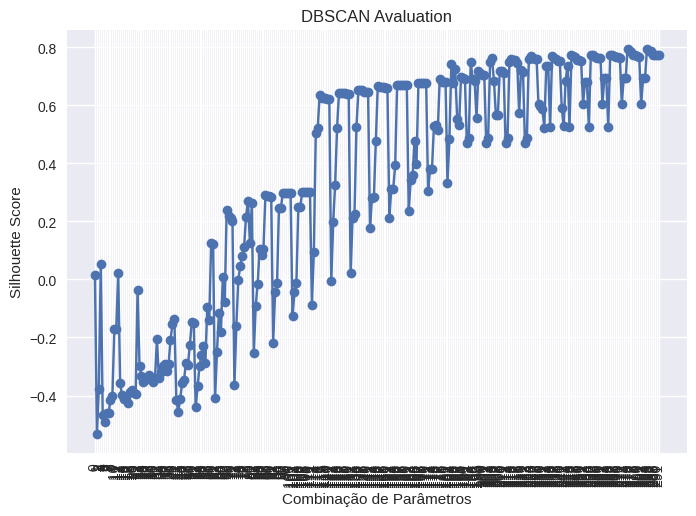

In [ ]:
# Plotagem do gráfico de avaliação
plt.plot(range(len(silhouette_scores)), silhouette_scores, marker='o')
plt.xlabel("Combinação de Parâmetros")
plt.ylabel("Silhouette Score")
plt.title("DBSCAN Avaluation")
plt.xticks(range(len(silhouette_scores)), rotation='vertical')
plt.show()

In [ ]:
df.shape

(3207, 10)

In [ ]:
title = "DBSCAN Clustering Results"
p = visualize_clustering_results(df, X_set, instance_names, cluster_labels, cluster_sizes, title)
X_set_clusters = {}
for (i, name) in enumerate(instance_names):
  if name.startswith("X-n"):
    c = cluster_labels[i]
    if c in X_set_clusters:
      X_set_clusters[c] += 1
    else:
      X_set_clusters[c] = 1
for (X_cluster, X_size) in X_set_clusters.items():
  print(f"Cluster {X_cluster}: {X_size} are X-set, {cluster_sizes[X_cluster+1]} in total")
output_file("dbscan_clustering_results.html", title=title)
save(p)

Cluster 0: 74 are X-set, 3175 in total
Cluster -1: 26 are X-set, 32 in total


'/content/dbscan_clustering_results.html'

# HDBSCAN

In [ ]:
df.shape

(3207, 10)

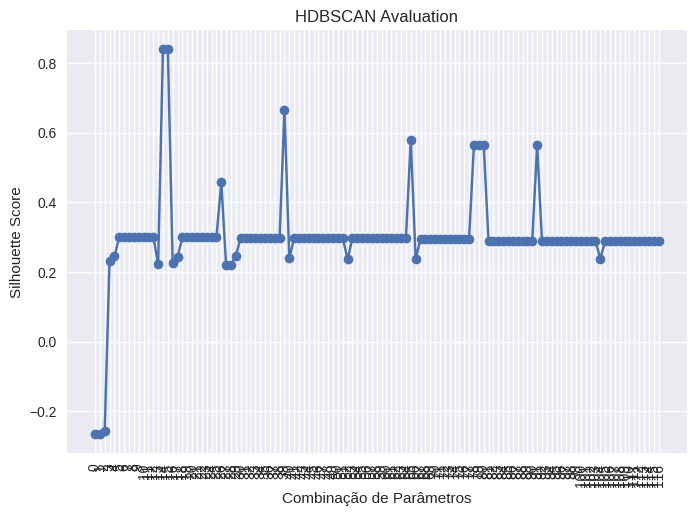

Parameters:
Best silhouette Coefficient:: 0.8390521148323656
Best min_samples value: 3
Best min_cluster_size value: 3
Estimated number of Clusters: 3


In [ ]:
# Lista de valores para min_samples e min_cluster_size
min_samples_range = range(2, 11)
min_cluster_size_range = range(2, 15)

# Lista para armazenar as métricas de avaliação
silhouette_scores = []
cluster_counts = []

# Variáveis para armazenar o melhor coeficiente de silhueta e os melhores parâmetros
best_silhouette = -1
best_min_samples = -1
best_min_cluster_size = -1

# Loop para testar diferentes combinações de parâmetros
for min_samples in min_samples_range:
    for min_cluster_size in min_cluster_size_range:
        # Configuração do HDBSCAN
        clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)

        # Aplicação do HDBSCAN aos dados
        labels = clusterer.fit_predict(df)

        # Verificar se existem pelo menos 2 clusters para calcular a métrica de silhueta
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1:
            # Cálculo da métrica de silhueta
            silhouette = silhouette_score(df, labels)
            silhouette_scores.append(silhouette)
            cluster_counts.append(len(unique_labels))

            # Atualização do melhor coeficiente de silhueta e dos melhores parâmetros
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_min_samples = min_samples
                best_min_cluster_size = min_cluster_size
                cluster_labels_v1 = clusterer.labels_
        else:
            silhouette_scores.append(np.nan)

_, cluster_sizes_v1 = np.unique(cluster_labels_v1, return_counts=True)

# Plotagem do gráfico de avaliação
plt.plot(range(len(silhouette_scores)), silhouette_scores, marker='o')
plt.xlabel("Combinação de Parâmetros")
plt.ylabel("Silhouette Score")
plt.title("HDBSCAN Avaluation")
plt.xticks(range(len(silhouette_scores)), rotation='vertical')
plt.show()

# Encontrar a combinação de parâmetros com o melhor silhouette score
best_index = np.nanargmax(silhouette_scores)
best_min_samples = min_samples_range[best_index // len(min_cluster_size_range)]
best_min_cluster_size = min_cluster_size_range[best_index % len(min_cluster_size_range)]

# Exibição dos resultados
print("Parameters:")
print(f"Best silhouette Coefficient:: {best_silhouette}")
print(f"Best min_samples value: {best_min_samples}")
print(f"Best min_cluster_size value: {best_min_cluster_size}")
print(f"Estimated number of Clusters: {cluster_counts[best_index]}")

In [ ]:
df.shape

(3207, 10)

###Gráfico

In [ ]:
title = "HDBSCAN Clustering Results"
p = visualize_clustering_results(df, X_set, instance_names, cluster_labels_v1, cluster_sizes_v1, title)
X_set_clusters = {}
for (i, name) in enumerate(instance_names):
  if name.startswith("X-n"):
    c = cluster_labels_v1[i]
    if c in X_set_clusters:
      X_set_clusters[c] += 1
    else:
      X_set_clusters[c] = 1
for (X_cluster, X_size) in X_set_clusters.items():
  print(f"Cluster {X_cluster}: {X_size} are X-set, {cluster_sizes_v1[X_cluster+1]} in total")
output_file("hdbscan_clustering_results.html", title=title)
save(p)

: 